# Demonstration of a common issue encountered in template matching

Templates are selected from Weiqiang Zhu's PhaseNet catalog.

--------------------------------------------------------------------

Download the seismic data at: https://doi.org/10.5281/zenodo.15097180

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.15097180.svg)](https://doi.org/10.5281/zenodo.15097180)

In [243]:
import os
import fast_matched_filter as fmf
import glob
import numpy as np
import matplotlib.pyplot as plt
import obspy as obs
import pandas as pd


In [244]:
# path variables and file names
DIR_WAVEFORMS = "/data/hy4/ebeauce/Ridgecrest/2019/"
DIR_CATALOG = "../picks_phasenet/"

STATION_FILE = "adloc_stations.csv"
EVENT_FILE = "adloc_events.csv"
PICK_FILE = "adloc_picks.csv"

## Load PhaseNet catalog

Here, we read the catalog of the 2019 Ridgecrest sequence made with PhaseNet. Information is divided into three files:
- a station metadata file,
- an event metadata file (the catalog per se),
- a pick database, which contains all the P- and S-wave picks found by PhaseNet.

In [245]:
station_meta = pd.read_csv(os.path.join(DIR_CATALOG, STATION_FILE))
station_meta

,network,station,location,instrument,component,latitude,longitude,elevation_m,depth_km,provider,station_id,station_term_time_p,station_term_time_s,station_term_amplitude
0,CI,CCC,NaN,BH,ENZ,35.524950,-117.364530,670.0,-0.6700,SCEDC,CI.CCC..BH,0.266086,0.500831,0.049399
1,CI,CCC,NaN,HH,ENZ,35.524950,-117.364530,670.0,-0.6700,SCEDC,CI.CCC..HH,0.295428,0.518465,0.191475
2,CI,CCC,NaN,HN,ENZ,35.524950,-117.364530,670.0,-0.6700,SCEDC,CI.CCC..HN,0.296263,0.541148,0.064485
3,CI,CLC,NaN,BH,ENZ,35.815740,-117.597510,775.0,-0.7750,SCEDC,CI.CLC..BH,-0.231963,-0.415271,-0.331371
4,CI,CLC,NaN,HH,ENZ,35.815740,-117.597510,775.0,-0.7750,SCEDC,CI.CLC..HH,-0.168743,-0.390045,-0.140313
5,CI,CLC,NaN,HN,ENZ,35.815740,-117.597510,775.0,-0.7750,SCEDC,CI.CLC..HN,-0.175671,-0.388116,-0.249066
6,CI,DTP,NaN,BH,ENZ,35.267420,-117.845810,908.0,-0.9080,SCEDC,CI.DTP..BH,-0.305881,-0.602459,-0.503411
7,CI,DTP,NaN,HH,ENZ,35.267420,-117.845810,908.0,-0.9080,SCEDC,CI.DTP..HH,-0.263705,-0.564867,-0.437951
8,CI,DTP,NaN,HN,ENZ,35.267420,-117.845810,908.0,-0.9080,SCEDC,CI.DTP..HN,-0.244383,-0.538990,-0.500516
9,CI,JRC2,NaN,BH,ENZ,35.982490,-117.808850,1469.0,-1.4690,SCEDC,CI.JRC2..BH,0.011361,-0.080285,-0.039941


The following shows a very rudimentary map of the station network. Look into the `cartopy` package for more sophisticated maps.

Text(0.5, 1.0, 'Stations used to build the PhaseNet catalog')

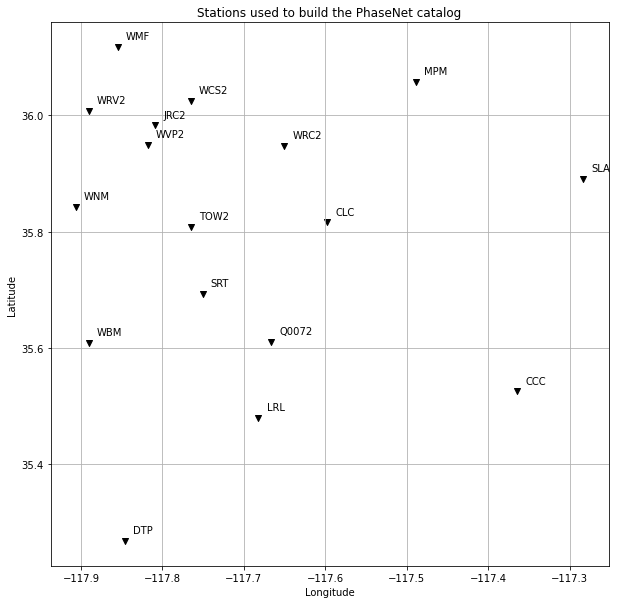

In [246]:
_station_meta = station_meta.drop_duplicates("station")

fig, ax = plt.subplots(num="station_network", figsize=(10, 10))
ax.scatter(_station_meta["longitude"], _station_meta["latitude"], marker="v", color="k")
for idx, row in _station_meta.iterrows():
    ax.text(row.longitude + 0.01, row.latitude + 0.01, row.station, va="bottom", ha="left")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid()
ax.set_title("Stations used to build the PhaseNet catalog")

In [247]:
event_meta = pd.read_csv(os.path.join(DIR_CATALOG, EVENT_FILE))
event_meta

,time,adloc_score,adloc_residual_time,num_picks,magnitude,adloc_residual_amplitude,event_index,longitude,latitude,depth_km
0,2019-07-04 00:46:47.342963596,0.866596,0.057355,35,0.595368,0.165480,6720,-117.882570,36.091088,4.643969
1,2019-07-04 00:55:32.648412579,0.781116,0.203567,16,1.142510,0.170509,17122,-117.799226,35.378160,11.078458
2,2019-07-04 00:56:37.232733104,0.908073,0.086183,42,0.912494,0.166681,5411,-117.880902,36.091986,4.854336
3,2019-07-04 02:00:39.149363202,0.814322,0.036164,15,0.209530,0.092534,17868,-117.866468,36.093520,4.981447
4,2019-07-04 03:05:31.018885833,0.799281,0.080708,11,0.104050,0.156833,25037,-117.846320,36.100386,5.943363
...,...,...,...,...,...,...,...,...,...,...
20898,2019-07-09 23:58:14.298499048,0.933013,0.097816,67,1.543257,0.131523,1907,-117.711811,35.926468,6.652020
20899,2019-07-09 23:58:47.701746285,0.882434,0.090185,73,1.087089,0.140159,2051,-117.604263,35.797450,6.617413
20900,2019-07-09 23:59:05.102247662,0.798047,0.435077,26,1.147040,0.170994,12567,-117.509729,35.692722,12.815041
20901,2019-07-09 23:59:40.257837813,0.971081,0.065523,35,1.161323,0.068586,7726,-117.846289,36.061435,5.224666


In [248]:
picks = pd.read_csv(os.path.join(DIR_CATALOG, PICK_FILE))
picks

,station_id,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude,event_index,sp_ratio,event_amplitude,adloc_mask,adloc_residual_time,adloc_residual_amplitude
0,CI.WMF..BH,280874,2019-07-04 00:46:48.759,0.594,P,0.01,0.110,-3.213107,6720,0.955091,3.124152e-07,1,0.003919,0.012320
1,CI.WMF..HH,280881,2019-07-04 00:46:48.818,0.973,P,0.01,0.938,-3.077638,6720,0.948896,3.368390e-07,1,0.026491,0.063669
2,CI.WMF..HN,280881,2019-07-04 00:46:48.818,0.973,P,0.01,0.898,-3.128019,6720,1.598008,2.146277e-07,1,0.017580,0.173702
3,CI.WRV2..EH,280945,2019-07-04 00:46:49.450,0.977,P,0.01,-0.855,-3.464453,6720,1.000000,3.298200e-07,1,0.077194,0.244381
4,CI.WRV2..HN,280945,2019-07-04 00:46:49.450,0.941,P,0.01,-0.906,-3.585863,6720,1.147235,3.908305e-07,1,0.056694,0.041691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955700,CI.WRV2..HN,8639355,2019-07-09 23:59:53.550,0.688,S,0.01,-0.022,-3.384471,18566,0.644492,1.973834e-06,1,0.019093,0.028409
955701,CI.JRC2..HH,8639499,2019-07-09 23:59:54.998,0.402,S,0.01,-0.023,-3.446238,18566,0.647843,6.197256e-06,1,0.020364,-0.154404
955702,CI.JRC2..HN,8639499,2019-07-09 23:59:54.998,0.344,S,0.01,-0.016,-3.531800,18566,0.731796,4.075353e-06,1,0.012773,-0.164659
955703,CI.WVP2..EH,8639574,2019-07-09 23:59:55.740,0.314,S,0.01,-0.103,-3.488117,18566,0.636005,2.815148e-06,1,-0.092233,0.316712


## Pick one event

Let's use the PhaseNet catalog to read the waveforms of an event.

In [249]:
def fetch_event_waveforms(
    event_picks,
    folder="preprocessed_2_12",
    dir_waveforms=DIR_WAVEFORMS,
    time_before_phase_onset_sec=2.0,
    duration_sec=10.0
    ):
    """
    Fetches the waveforms for a given event based on the picks.

    Parameters
    ----------
    event_picks : pandas.DataFrame
        DataFrame containing the picks for the event.
    folder : str, optional
        Folder name where the preprocessed waveforms are stored, by default "preprocessed_2_12".
    dir_waveforms : str, optional
        Directory where the waveform data is stored, by default DIR_WAVEFORMS.
    time_before_phase_onset_sec : float, optional
        Time in seconds to start the waveform before the phase onset, by default 2.0.
    duration_sec : float, optional
        Duration in seconds of the waveform to fetch, by default 10.0.

    Returns
    -------
    obspy.Stream
        Stream object containing the fetched waveforms.
    """
    date = pd.Timestamp(event_picks.iloc[0]["phase_time"]).strftime("%Y-%m-%d")
    # full path to waveform directory for this given day
    dir_data = os.path.join(dir_waveforms, date.replace("-", ""), folder)
    stream = obs.Stream()
    for _, pick in event_picks.iterrows():
        # check whether we have a miniseed file for this waveform
        if pick.phase_type == "P":
            files = glob.glob(os.path.join(dir_data, pick.station_id + "Z*mseed"))
        elif pick.phase_type == "S":
            files = glob.glob(os.path.join(dir_data, pick.station_id + "[N,E]*mseed"))
        starttime = obs.UTCDateTime(pick.phase_time) - time_before_phase_onset_sec
        endtime = starttime + duration_sec
        for _file in files:
            stream += obs.read(
                _file,
                starttime=starttime,
                endtime=endtime
            )
    return stream
    

In [250]:
# explore event_meta to find a nice intermediate-size earthquake we could plot
event_meta.head(20)

,time,adloc_score,adloc_residual_time,num_picks,magnitude,adloc_residual_amplitude,event_index,longitude,latitude,depth_km
0,2019-07-04 00:46:47.342963596,0.866596,0.057355,35,0.595368,0.165480,6720,-117.882570,36.091088,4.643969
1,2019-07-04 00:55:32.648412579,0.781116,0.203567,16,1.142510,0.170509,17122,-117.799226,35.378160,11.078458
2,2019-07-04 00:56:37.232733104,0.908073,0.086183,42,0.912494,0.166681,5411,-117.880902,36.091986,4.854336
3,2019-07-04 02:00:39.149363202,0.814322,0.036164,15,0.209530,0.092534,17868,-117.866468,36.093520,4.981447
4,2019-07-04 03:05:31.018885833,0.799281,0.080708,11,0.104050,0.156833,25037,-117.846320,36.100386,5.943363
5,2019-07-04 03:20:28.674438914,0.755451,0.050436,44,0.869927,0.111885,6929,-117.673684,36.114308,5.894466
6,2019-07-04 04:03:01.619369274,0.897311,0.143631,32,0.386310,0.214381,7607,-117.805077,36.016063,0.396071
7,2019-07-04 05:16:47.223353119,0.835094,0.053522,22,0.575433,0.163675,13098,-117.879256,36.090409,4.268292
8,2019-07-04 06:57:32.758991812,0.922386,0.065846,23,0.256281,0.065212,15698,-117.867587,36.081665,5.939931
9,2019-07-04 11:51:07.805591259,0.692042,0.075023,48,0.818316,0.102087,4380,-117.671909,36.118573,6.085804


In [251]:
# feel free to play with the event index to plot different events
EVENT_IDX = 1101

event_meta.set_index("event_index").loc[EVENT_IDX]

time                        2019-07-04 17:02:55.057058245
adloc_score                                      0.770696
adloc_residual_time                              0.079675
num_picks                                              90
magnitude                                        4.476724
adloc_residual_amplitude                         0.143489
longitude                                     -117.495094
latitude                                        35.711607
depth_km                                        13.586411
Name: 1101, dtype: object

In [252]:
# fetch the corresponding picks for this event
event_picks = picks[picks["event_index"] == EVENT_IDX]
event_picks

,station_id,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude,event_index,sp_ratio,event_amplitude,adloc_mask,adloc_residual_time,adloc_residual_amplitude
565,CI.CLC..HN,6137848,2019-07-04 17:02:58.488,0.969,P,0.01,-0.879,-0.511873,1101,1.017569,2.474507e-07,1,-0.010048,-0.054426
566,CI.CLC..BH,6137847,2019-07-04 17:02:58.489,0.633,P,0.01,-0.324,-0.666956,1101,1.014822,2.022085e-07,1,0.048153,-0.127168
567,CI.CLC..HH,6137849,2019-07-04 17:02:58.498,0.965,P,0.01,-0.883,-0.586030,1101,1.086886,2.141392e-07,1,-0.007135,-0.236796
568,CI.SRT..HN,6137990,2019-07-04 17:02:59.908,0.879,P,0.01,0.699,-0.643401,1101,1.377537,4.387864e-07,1,-0.069463,0.065039
569,CI.SRT..HH,6137990,2019-07-04 17:02:59.908,0.891,P,0.01,0.734,-0.601019,1101,0.729745,5.910421e-07,1,-0.078144,0.020251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,CI.WMF..HH,6139185,2019-07-04 17:03:11.858,0.672,S,0.01,0.021,-1.368759,1101,1.096820,3.073536e-07,1,0.140179,-0.329117
651,CI.WMF..HN,6139189,2019-07-04 17:03:11.898,0.633,S,0.01,0.026,-1.371407,1101,0.989939,2.891483e-07,1,0.159858,-0.171350
652,CI.DTP..BH,6139200,2019-07-04 17:03:12.019,0.734,S,0.01,0.035,-1.322484,1101,1.385395,1.624267e-07,1,0.068940,0.175198
653,CI.DTP..HH,6139203,2019-07-04 17:03:12.038,0.707,S,0.01,-0.015,-1.306977,1101,1.122809,3.205840e-07,1,0.052824,0.125587


In [253]:
# fetch the waveforms
event_waveforms = fetch_event_waveforms(event_picks, time_before_phase_onset_sec=10., duration_sec=30.)
print(event_waveforms.__str__(extended=True))

42 Trace(s) in Stream:
CI.CLC..HHZ  | 2019-07-04T17:02:48.478300Z - 2019-07-04T17:03:18.478300Z | 25.0 Hz, 751 samples
CI.SRT..HHZ  | 2019-07-04T17:02:49.918300Z - 2019-07-04T17:03:19.918300Z | 25.0 Hz, 751 samples
CI.CCC..HHZ  | 2019-07-04T17:02:50.118300Z - 2019-07-04T17:03:20.118300Z | 25.0 Hz, 751 samples
CI.SLA..HHZ  | 2019-07-04T17:02:50.518300Z - 2019-07-04T17:03:20.518300Z | 25.0 Hz, 751 samples
CI.TOW2..HHZ | 2019-07-04T17:02:50.518300Z - 2019-07-04T17:03:20.518300Z | 25.0 Hz, 751 samples
CI.LRL..HHZ  | 2019-07-04T17:02:50.638300Z - 2019-07-04T17:03:20.638300Z | 25.0 Hz, 751 samples
CI.WRC2..HHZ | 2019-07-04T17:02:50.718300Z - 2019-07-04T17:03:20.718300Z | 25.0 Hz, 751 samples
CI.CLC..HHE  | 2019-07-04T17:02:50.958300Z - 2019-07-04T17:03:20.958300Z | 25.0 Hz, 751 samples
CI.CLC..HHN  | 2019-07-04T17:02:50.958300Z - 2019-07-04T17:03:20.958300Z | 25.0 Hz, 751 samples
CI.MPM..HHZ  | 2019-07-04T17:02:52.038300Z - 2019-07-04T17:03:22.038300Z | 25.0 Hz, 751 samples
CI.WBM..HHZ  | 20

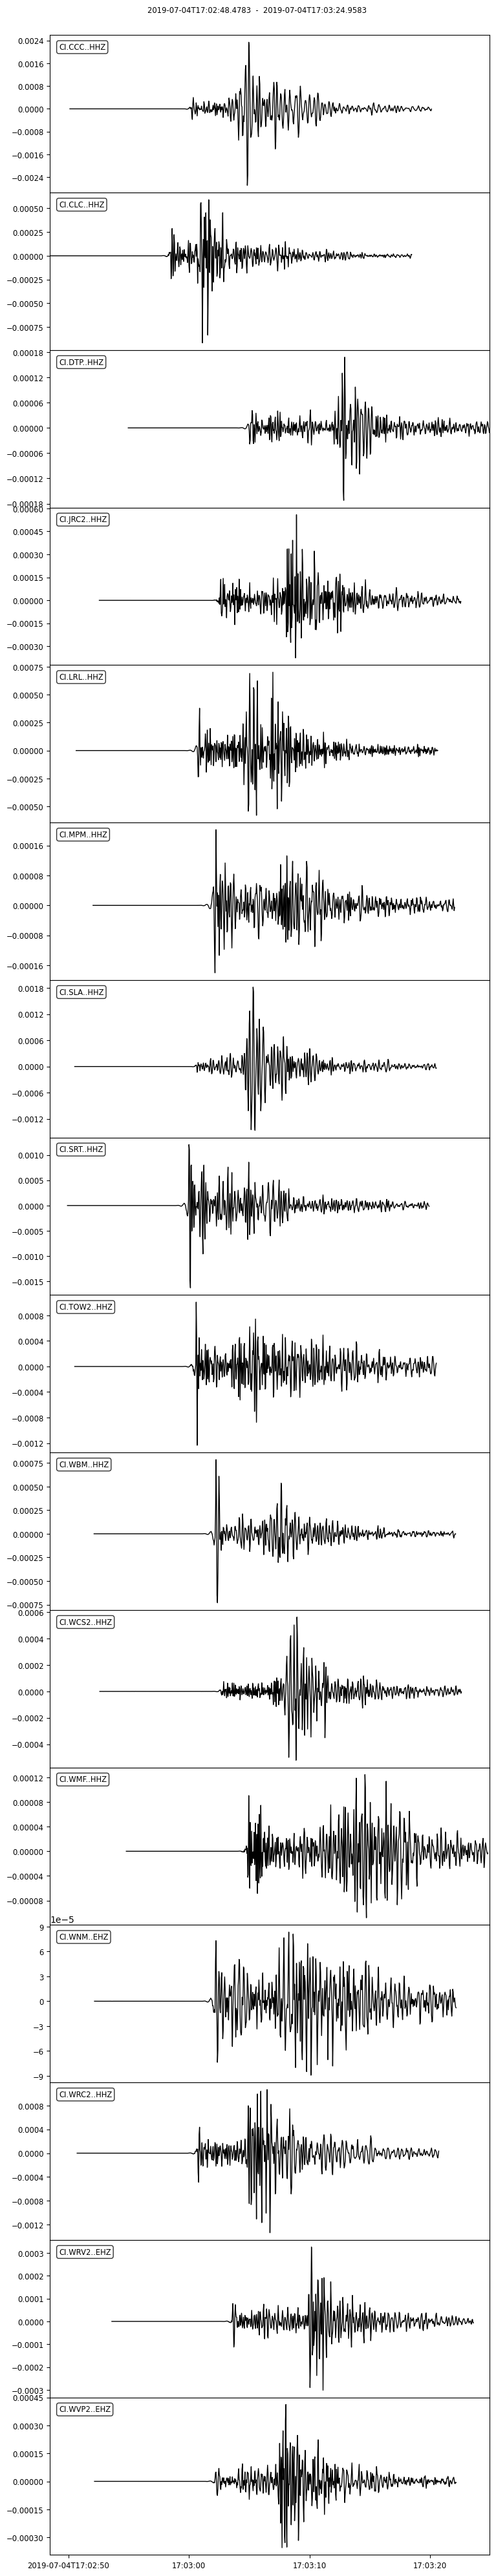

In [254]:
# plot them!
fig = event_waveforms.select(component="Z").plot(equal_scale=False)

## Run template matching

We will now use one of the events from the PhaseNet catalog as a **template** event to detect events with template matching.

In [255]:
selected_event_meta = event_meta.set_index("event_index").loc[EVENT_IDX]
selected_event_meta

time                        2019-07-04 17:02:55.057058245
adloc_score                                      0.770696
adloc_residual_time                              0.079675
num_picks                                              90
magnitude                                        4.476724
adloc_residual_amplitude                         0.143489
longitude                                     -117.495094
latitude                                        35.711607
depth_km                                        13.586411
Name: 1101, dtype: object

In [256]:
selected_event_picks = picks[picks["event_index"] == EVENT_IDX]
selected_event_picks

,station_id,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude,event_index,sp_ratio,event_amplitude,adloc_mask,adloc_residual_time,adloc_residual_amplitude
565,CI.CLC..HN,6137848,2019-07-04 17:02:58.488,0.969,P,0.01,-0.879,-0.511873,1101,1.017569,2.474507e-07,1,-0.010048,-0.054426
566,CI.CLC..BH,6137847,2019-07-04 17:02:58.489,0.633,P,0.01,-0.324,-0.666956,1101,1.014822,2.022085e-07,1,0.048153,-0.127168
567,CI.CLC..HH,6137849,2019-07-04 17:02:58.498,0.965,P,0.01,-0.883,-0.586030,1101,1.086886,2.141392e-07,1,-0.007135,-0.236796
568,CI.SRT..HN,6137990,2019-07-04 17:02:59.908,0.879,P,0.01,0.699,-0.643401,1101,1.377537,4.387864e-07,1,-0.069463,0.065039
569,CI.SRT..HH,6137990,2019-07-04 17:02:59.908,0.891,P,0.01,0.734,-0.601019,1101,0.729745,5.910421e-07,1,-0.078144,0.020251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,CI.WMF..HH,6139185,2019-07-04 17:03:11.858,0.672,S,0.01,0.021,-1.368759,1101,1.096820,3.073536e-07,1,0.140179,-0.329117
651,CI.WMF..HN,6139189,2019-07-04 17:03:11.898,0.633,S,0.01,0.026,-1.371407,1101,0.989939,2.891483e-07,1,0.159858,-0.171350
652,CI.DTP..BH,6139200,2019-07-04 17:03:12.019,0.734,S,0.01,0.035,-1.322484,1101,1.385395,1.624267e-07,1,0.068940,0.175198
653,CI.DTP..HH,6139203,2019-07-04 17:03:12.038,0.707,S,0.01,-0.015,-1.306977,1101,1.122809,3.205840e-07,1,0.052824,0.125587


### Read data from same day

In [257]:
def fetch_day_waveforms(date, folder="preprocessed_2_12", dir_waveforms=DIR_WAVEFORMS):
    """
    Fetches the continuous seismograms for a given day.

    Parameters
    ----------
    date : str or pandas.Timestamp
        The date for which to fetch the continuous seismograms.
    folder : str, optional
        Folder name where the preprocessed continuous seismograms are stored, by default "preprocessed_2_12".
    dir_waveforms : str, optional
        Directory where the waveform data is stored, by default DIR_WAVEFORMS.

    Returns
    -------
    obspy.Stream
        Stream object containing the fetched continuous seismograms.
    """
    date = pd.Timestamp(date)
    # full path to waveform directory for this given day
    dir_data = os.path.join(dir_waveforms, date.strftime("%Y%m%d"), folder)
    stream = obs.Stream()
    files = glob.glob(os.path.join(dir_data, "*mseed"))
    for _file in files:
        stream += obs.read(_file)
    return stream

In [258]:
# first, read the continuous seismograms into an `obspy.Stream`
date = pd.Timestamp(selected_event_meta.time).strftime("%Y-%m-%d")
continuous_seismograms = fetch_day_waveforms(date)
print(continuous_seismograms.__str__(extended=True))

57 Trace(s) in Stream:
PB.B921..EHZ | 2019-07-03T23:59:59.998200Z - 2019-07-04T23:59:59.958200Z | 25.0 Hz, 2160000 samples
PB.B917..EHZ | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.JRC2..HHN | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.SRT..HHZ  | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.WCS2..HHE | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
PB.B917..EH1 | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.MPM..HHZ  | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.MPM..HHE  | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
CI.JRC2..HHE | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25.0 Hz, 2160000 samples
PB.B917..EH2 | 2019-07-03T23:59:59.998300Z - 2019-07-04T23:59:59.958300Z | 25

### Introduce gaps in some stations

In [259]:
GAP_START_SEC = 3. * 60. * 60. 
GAP_END_SEC = 14. * 60. * 60.
station_list = list(set([st.stats.station for st in continuous_seismograms]))
STATIONS_W_GAP = np.random.choice(
    station_list, size=int(3. / 4. * len(station_list)), replace=False
)
for sta in STATIONS_W_GAP:
    for tr in continuous_seismograms.select(station=sta):
        gap_start_samp = int(GAP_START_SEC * tr.stats.sampling_rate)
        gap_end_samp = int(GAP_END_SEC * tr.stats.sampling_rate)
        tr.data[gap_start_samp:gap_end_samp] = 0.

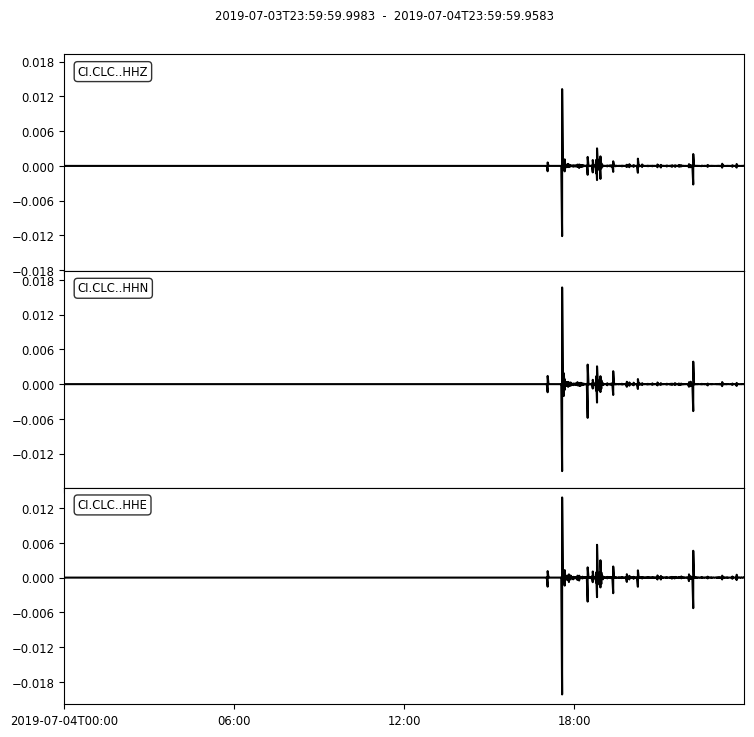

In [260]:
# plot the continuous seismograms from a single station
fig = continuous_seismograms.select(station="CLC").plot()

In [261]:
# then, cast data into `numpy.ndarray`
station_codes = list(set([st.stats.station for st in continuous_seismograms]))
component_codes = ["N", "E", "Z"]
component_aliases={"E": ["E", "2"], "N": ["N", "1"], "Z": ["Z"]}

num_stations = len(station_codes)
num_channels = len(component_codes)
num_samples = len(continuous_seismograms[0].data)

continuous_seismograms_arr = np.zeros((num_stations, num_channels, num_samples), dtype=np.float32)
for s, sta in enumerate(station_codes):
    for c, cp in enumerate(component_codes):
        for cp_alias in component_aliases[cp]:
            sel_seismogram = continuous_seismograms.select(station=sta, component=cp_alias)
            if len(sel_seismogram) > 0:
                continuous_seismograms_arr[s, c, :] = sel_seismogram[0].data
                break
            
continuous_seismograms_arr


array([[[ 1.4600339e-10, -5.3098227e-11,  2.6053208e-11, ...,
         -1.7609335e-10, -1.0757958e-09, -3.2304073e-10],
        [-1.8837293e-10, -3.9537898e-10,  6.1877975e-10, ...,
          1.2199616e-09, -4.3733478e-10, -1.2359246e-10],
        [-3.7269673e-10, -3.1777814e-10, -4.1399570e-10, ...,
          3.9447723e-11,  3.8182132e-10,  5.4754090e-10]],

       [[-1.6893502e-11,  8.4201196e-12,  2.7799072e-11, ...,
         -1.7474208e-10, -4.5014548e-11, -2.6048433e-10],
        [ 1.4196522e-11,  3.8935088e-12, -2.4043532e-12, ...,
         -4.9603099e-11, -9.2666923e-11,  2.2229388e-10],
        [-7.8133723e-12,  1.1610854e-11,  1.2903780e-11, ...,
         -8.2966682e-11, -9.3903114e-11, -8.1583212e-12]],

       [[ 2.3738601e-11,  1.5366581e-11, -3.4090290e-11, ...,
         -6.4372863e-10,  2.9770833e-10,  4.5607784e-10],
        [-2.5375939e-11, -4.2040114e-11, -6.9413607e-11, ...,
          2.6399483e-09, -1.9696462e-09, -2.6043785e-09],
        [-7.4437045e-12, -5.6260854e

### Build template 

#### ------------------ Background ------------------

A template is a collection of waveforms at different channels, $T_{s,c}(t)$, which are clips taken from the continuous seismograms, $u_{s,c}$. These clips are taken at times defined by:
$$ u_{s,c}(t)\ |\ t \in \lbrace \tau_{s,c}; \tau_{s,c} + D \rbrace, $$
where $\tau_{s,c}$ is the start time of the template window and $D$ is the template duration.

$\tau_{s,c}$ is given by some prior information on the event: picks or modeled arrival times. The **moveouts**, $\tilde{\tau}_{s,c}$, are the collection of delay times relative to the earliest $\tau_{s,c}$:
$$ \tilde{\tau}_{s,c} = \tau_{s,c} - \underset{s,c}{\min} \lbrace \tau_{s,c} \rbrace .$$

#### ------------------ On the necessity to clip template waveforms out of `numpy.ndarray` instead of `obspy.Stream` ------------------

Looking carefully at the output of `print(continuous_seismograms.__str__(extended=True))`, a few cells before, we see that start times are generally not exactly at midnight. This is a consequence of the discrete nature of the continuous seismograms (here, sampled at 25 samples per second). Thus, in general, the $\tau_{s,c}$ computed from picks or modeled arrival times fall in between two samples of the seismograms.

When running a matched-filter search, we need to make sure the moveouts, $\tilde{\tau}_{s,c}$, ultimately expressed in samples, match exactly the times that were used when clipping the template waveforms out of $u_{s,c}$. One way to ensure this is to first cast the $\tau_{s,c}$ to times in samples and then operate exclusively on the `numpy.ndarray`: `continuous_seismograms_arr`:

$$ T_{s,c}[t_n] = u_{s,c}[\tau_{s,c} + n \Delta t],$$
where $\Delta t$ is the sampling time.

#### Clip out waveforms and moveout and station-weight arrays

In [262]:
# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform.
#                Here, we use windows centered around the S wave for horizontal components
#                and windows starting 1sec before the P wave for the vertical component.
PHASE_ON_COMP = {"N": "S", "E": "S", "Z": "P"}
# OFFSET_PHASE_SEC: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE_SEC["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE_SEC = {"P": 1.0, "S": 4.0}
# TEMPLATE_DURATION_SEC
TEMPLATE_DURATION_SEC = 8. 
# SAMPLING_RATE_HZ
SAMPLING_RATE_HZ = 25.
# TEMPLATE_DURATION_SAMP
TEMPLATE_DURATION_SAMP = int(TEMPLATE_DURATION_SEC * SAMPLING_RATE_HZ)


In [263]:
# add station_code columns to `selected_event_picks`
selected_event_picks.set_index("station_id", inplace=True)
for staid in selected_event_picks.index:
    station_code = staid.split(".")[1]
    selected_event_picks.loc[staid, "station_code"] = station_code
selected_event_picks

/tmp/ipykernel_2901463/1881751651.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_event_picks.loc[staid, "station_code"] = station_code


,phase_index,phase_time,phase_score,phase_type,dt_s,phase_polarity,phase_amplitude,event_index,sp_ratio,event_amplitude,adloc_mask,adloc_residual_time,adloc_residual_amplitude,station_code
station_id,,,,,,,,,,,,,,
CI.CLC..HN,6137848,2019-07-04 17:02:58.488,0.969,P,0.01,-0.879,-0.511873,1101,1.017569,2.474507e-07,1,-0.010048,-0.054426,CLC
CI.CLC..BH,6137847,2019-07-04 17:02:58.489,0.633,P,0.01,-0.324,-0.666956,1101,1.014822,2.022085e-07,1,0.048153,-0.127168,CLC
CI.CLC..HH,6137849,2019-07-04 17:02:58.498,0.965,P,0.01,-0.883,-0.586030,1101,1.086886,2.141392e-07,1,-0.007135,-0.236796,CLC
CI.SRT..HN,6137990,2019-07-04 17:02:59.908,0.879,P,0.01,0.699,-0.643401,1101,1.377537,4.387864e-07,1,-0.069463,0.065039,SRT
CI.SRT..HH,6137990,2019-07-04 17:02:59.908,0.891,P,0.01,0.734,-0.601019,1101,0.729745,5.910421e-07,1,-0.078144,0.020251,SRT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CI.WMF..HH,6139185,2019-07-04 17:03:11.858,0.672,S,0.01,0.021,-1.368759,1101,1.096820,3.073536e-07,1,0.140179,-0.329117,WMF
CI.WMF..HN,6139189,2019-07-04 17:03:11.898,0.633,S,0.01,0.026,-1.371407,1101,0.989939,2.891483e-07,1,0.159858,-0.171350,WMF
CI.DTP..BH,6139200,2019-07-04 17:03:12.019,0.734,S,0.01,0.035,-1.322484,1101,1.385395,1.624267e-07,1,0.068940,0.175198,DTP


In the following cell, we build the `numpy.ndarray` of moveouts $\tilde{\tau}_{s,c}$, expressed in units of samples.

In [264]:
# first, we extract the set of relative delay times of the beginning of each
# template window on a given station and component
tau_s_c_sec = np.zeros((num_stations, num_channels), dtype=np.float64)
for s, sta in enumerate(station_codes):
    for c, cp in enumerate(component_codes):
        phase_type = PHASE_ON_COMP[cp]
        picks_s_c = selected_event_picks[
            (
                (selected_event_picks["station_code"] == sta)
                & (selected_event_picks["phase_type"] == phase_type)
            )
        ]
        if len(picks_s_c) == 0:
            # no pick for this station/component: set to -999
            tau_s_c_sec[s, c] = -999
        elif len(picks_s_c) == 1:
            # express pick relative to beginning of day (midnight)
            _pick = pd.Timestamp(picks_s_c["phase_time"])
            _relative_pick_sec = (_pick - pd.Timestamp(_pick.strftime("%Y-%m-%d"))).total_seconds()
            tau_s_c_sec[s, c] = _relative_pick_sec - OFFSET_PHASE_SEC[phase_type]
        else:
            # there were several picks from different channels: average them
            _relative_pick_sec = 0.
            for _pick in picks_s_c["phase_time"].values:
                _pick = pd.Timestamp(_pick)
                _relative_pick_sec += (_pick - pd.Timestamp(_pick.strftime("%Y-%m-%d"))).total_seconds()
            _relative_pick_sec /= float(len(picks_s_c["phase_time"]))
            tau_s_c_sec[s, c] = _relative_pick_sec - OFFSET_PHASE_SEC[phase_type]
# now, we convert these relative times into samples 
# and express them relative to the earliest time
# we also store in memory the minimum time offset `tau_min_samp` for the next step
moveouts_samp_arr = (tau_s_c_sec * SAMPLING_RATE_HZ).astype(np.int64)
tau_min_samp = np.min(moveouts_samp_arr[moveouts_samp_arr > 0])
moveouts_samp_arr = moveouts_samp_arr - tau_min_samp
moveouts_samp_arr

array([[      72,       72,       48],
       [-1559399, -1559399, -1559399],
       [     101,      101,       68],
       [      78,       78,       53],
       [     102,      102,       64],
       [-1559399, -1559399, -1559399],
       [     277,      277,      174],
       [-1559399, -1559399, -1559399],
       [     225,      225,      140],
       [     159,      159,      102],
       [     179,      179,      116],
       [     165,      165,      105],
       [       0,        0,       13],
       [      91,       91,       62],
       [      94,       94,       66],
       [     160,      160,      105],
       [     272,      272,      171],
       [-1559399, -1559399, -1559399],
       [-1559399, -1559399, -1559399],
       [     156,      156,      104],
       [     175,      175,      115]])

Next, we use the moveouts, in samples, to clip out the relevant template waveforms from the continuous seismograms.

In [265]:
template_waveforms_arr = np.zeros((num_stations, num_channels, TEMPLATE_DURATION_SAMP), dtype=np.float32)
weights_arr = np.ones((num_stations, num_channels), dtype=np.float32)

for s, sta in enumerate(station_codes):
    for c, cp in enumerate(component_codes):
        if moveouts_samp_arr[s, c] < 0:
            # no picks were found on this station
            weights_arr[s, c] = 0.
            continue
        starttime = tau_min_samp + moveouts_samp_arr[s, c]
        endtime = starttime + TEMPLATE_DURATION_SAMP
        template_waveforms_arr[s, c, :] = continuous_seismograms_arr[s, c, starttime:endtime]
        if template_waveforms_arr[s, c, :].sum() == 0.:
            # no data was available on this channel
            weights_arr[s, c] = 0.
        
template_waveforms_arr

array([[[ 3.89616571e-06,  3.75499076e-06,  2.80661197e-06, ...,
         -4.25717619e-04, -3.03944806e-04, -9.97306197e-05],
        [ 2.60295219e-05,  2.94552174e-05,  1.92641182e-05, ...,
          8.96334459e-05, -1.31632056e-04, -3.62226798e-04],
        [-7.62691286e-07,  9.61320339e-08,  1.22636879e-06, ...,
         -6.00129250e-04, -1.33479378e-04,  1.04399085e-04]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.66893849e-04, -2.58728869e-05,  6.50364236e-05, ...,
         -7.73223348e-07, -1.86355668e-04, -9.10725430e-05],
        [-1.66780126e-04, -1.16682213e-05,  5.75094709e-05, ...,
          6.42596220e-04,  1.95589619e-05, -4.814

In [266]:
# normalize template waveforms for numerical reasons
norm = np.std(template_waveforms_arr, axis=-1, keepdims=True)
norm[norm == 0.] = 1. 
template_waveforms_arr /= norm

# normalize weights so that they sum up to one
weights_arr /= np.sum(weights_arr)

# normalize continuous seismograms for numerical reasons
norm = np.std(continuous_seismograms_arr, axis=-1, keepdims=True)
norm[norm == 0.] = 1. 
continuous_seismograms_arr /= norm

### Run FMF

After all this data formatting, we can now run template matching (also called matched-filtering) to detect new events that are similar to our template event.

For that, use the software Fast Matched Filter (FMF): [https://github.com/beridel/fast_matched_filter](https://github.com/beridel/fast_matched_filter)

FMF offers C and CUDA-C routines to efficiently run template matching on CPUs, or even on GPUs if available to you.

In [267]:
# FMF_STEP_SAMP: this is the step between two consecutive calculation of the correlation coefficient
FMF_STEP_SAMP = 1
# ARCH: it determines whether you want to use GPUs or CPUs 
#       If you do not have an Nvidia GPU, set ARCH = "cpu"
ARCH = "gpu"

In [268]:
cc = fmf.matched_filter(
    template_waveforms_arr.astype(np.float32),
    moveouts_samp_arr.astype(np.int32),
    weights_arr.astype(np.float32),
    continuous_seismograms_arr.astype(np.float32),
    FMF_STEP_SAMP,
    arch=ARCH,
)

In [269]:
# FMF is programmed to handle multiple templates at once. Here, we only used
# a single template, hence the size of the outermost axis of "1"
cc.shape

(1, 2159801)

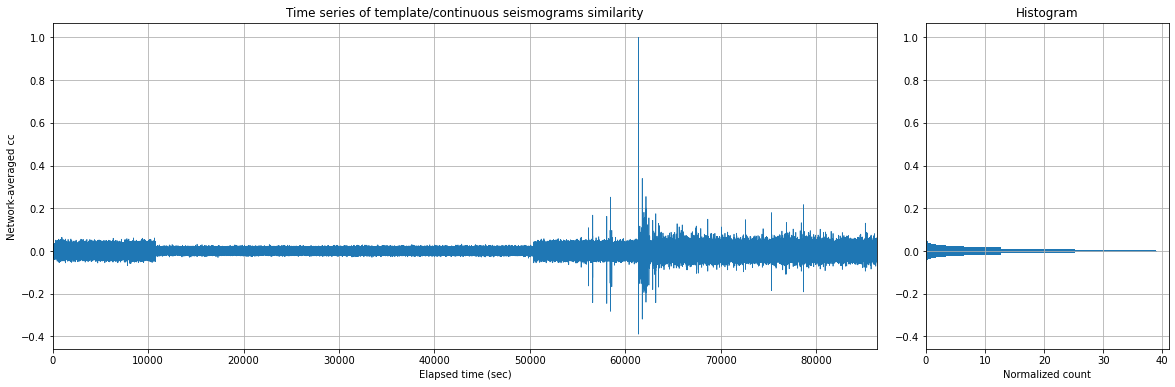

In [270]:
# let's print the output of our template matching run, which a time series of network-averaged correlation coefficients
# of same duration as the continuous seismograms
_cc = cc[0, :]
time_cc = np.arange(len(_cc)) / SAMPLING_RATE_HZ

fig = plt.figure("network_averaged_cc", figsize=(20, 6))
gs = fig.add_gridspec(ncols=4)

ax1 = fig.add_subplot(gs[:3])
ax1.plot(time_cc, _cc, lw=0.75)
ax1.set_xlabel("Elapsed time (sec)")
ax1.set_ylabel("Network-averaged cc")
ax1.set_xlim(time_cc.min(), time_cc.max())
ax1.set_title("Time series of template/continuous seismograms similarity")

ax2 = fig.add_subplot(gs[3], sharey=ax1)
_ = ax2.hist(_cc, orientation="horizontal", bins=250, density=True)
ax2.set_xlabel("Normalized count")
ax2.set_title("Histogram")

for ax in [ax1, ax2]:
    ax.grid()


### Set detection threshold and find events

We will use the time series of correlation coefficients to build an earthquake catalog. For that, we need to set a detection threshold and define all times above that threshold as triggers caused by near-repeats of the template event.

In [271]:
def select_cc_indexes(
    cc_t,
    threshold,
    search_win,
):
    """Select the peaks in the CC time series.

    Parameters
    ------------
    cc_t: (n_corr,) numpy.ndarray
        The CC time series for one template.
    threshold: (n_corr,) numpy.ndarray or scalar
        The detection threshold.
    search_win: scalar int
        The minimum inter-event time, in units of correlation step.


    Returns
    --------
    cc_idx: (n_detections,) numpy.ndarray
        The list of all selected CC indexes. They give the timings of the
        detected events.
    """

    cc_detections = cc_t > threshold
    cc_idx = np.where(cc_detections)[0]

    cc_idx = list(cc_idx)
    n_rm = 0
    for i in range(1, len(cc_idx)):
        if (cc_idx[i - n_rm] - cc_idx[i - n_rm - 1]) < search_win:
            if cc_t[cc_idx[i - n_rm]] > cc_t[cc_idx[i - n_rm - 1]]:
                # keep (i-n_rm)-th detection
                cc_idx.remove(cc_idx[i - n_rm - 1])
            else:
                # keep (i-n_rm-1)-th detection
                cc_idx.remove(cc_idx[i - n_rm])
            n_rm += 1
    cc_idx = np.asarray(cc_idx)
    return cc_idx
    

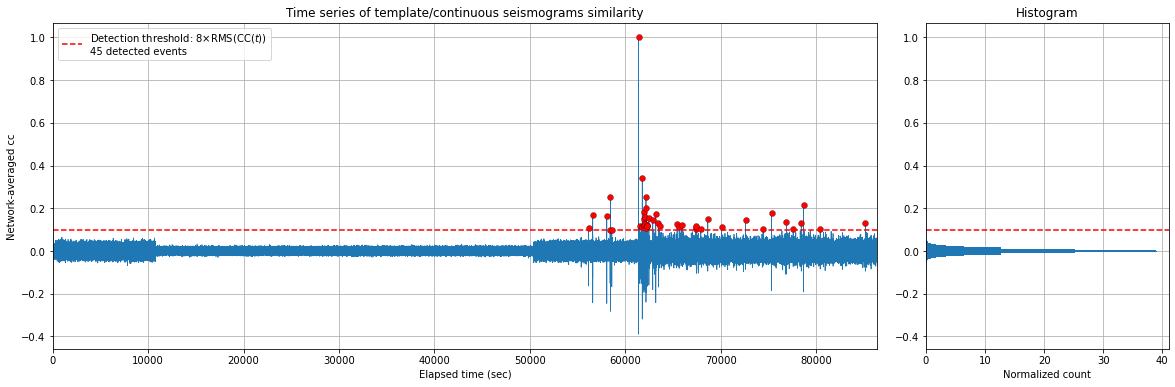

In [272]:
# INTEREVENT_TIME_RESOLUTION_SEC: In some cases, a template might trigger multiple, closely spaced detections because
#                                 of a phenomenon similar to that of "cycle skipping", where the waveform correlates
#                                 well with a time-shifted version of itself. Thus, to avoid redundant detections, we
#                                 set a minimum time separation between triggers (rule of thumb: about half the template duration)
INTEREVENT_TIME_RESOLUTION_SEC = 5.
INTEREVENT_TIME_RESOLUTION_SAMP = int(INTEREVENT_TIME_RESOLUTION_SEC * SAMPLING_RATE_HZ)
_cc = cc[0, :]
time_cc = np.arange(len(_cc)) * FMF_STEP_SAMP / SAMPLING_RATE_HZ
NUM_RMS = 8.
detection_threshold = NUM_RMS * np.std(_cc)
event_cc_indexes = select_cc_indexes(_cc, detection_threshold, INTEREVENT_TIME_RESOLUTION_SAMP)

fig = plt.figure("network_averaged_cc", figsize=(20, 6))
gs = fig.add_gridspec(ncols=4)

ax1 = fig.add_subplot(gs[:3])
ax1.plot(time_cc, _cc, lw=0.75)
ax1.scatter(time_cc[event_cc_indexes], _cc[event_cc_indexes], linewidths=0.25, edgecolor="k", color="r", zorder=2)
ax1.set_xlabel("Elapsed time (sec)")
ax1.set_ylabel("Network-averaged cc")
ax1.set_xlim(time_cc.min(), time_cc.max())
ax1.set_title("Time series of template/continuous seismograms similarity")

ax2 = fig.add_subplot(gs[3], sharey=ax1)
_ = ax2.hist(_cc, orientation="horizontal", bins=250, density=True, zorder=2)
ax2.set_xlabel("Normalized count")
ax2.set_title("Histogram")

label = f"Detection threshold: {NUM_RMS:.0f}"r"$\times \mathrm{RMS}(\mathrm{CC}(t))$"f"\n{len(event_cc_indexes):d} detected events"
for ax in [ax1, ax2]:
    ax.grid()
    ax.axhline(
        detection_threshold, ls="--", color="r",
        label=label
        )
ax1.legend(loc="upper left")

The time variation of the standard deviations of $CC(t)$ caused by gaps in some of the stations may lower the detection threshold and may thus trigger many false detections. In general, it's better to use a time-dependent detection threshold to adapt to possible gaps in the data. When using template matching on smaller seismic networks than in this example, a gap in a single station may strongly affect your time series $CC(t)$!

Interested in a bullet-proof time-dependent threshold? Check out the link below:
[https://ebeauce.github.io/Seismic_BPMF/usage/api/similarity_search.html#BPMF.similarity_search.time_dependent_threshold](https://ebeauce.github.io/Seismic_BPMF/usage/api/similarity_search.html#BPMF.similarity_search.time_dependent_threshold)